## Assignment 2 - Fashion Segmentation

#### Author: Joaquim Marset Alsina

### Required Installs

In [ ]:
# Install MMCV
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html
# Install MMSegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
# %cd mmsegmentation
# !pip install -e .
# %cd ..

### Imports

In [1]:
from inference import perform_inference, generate_segmentation_comparison_images
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plot_utils import *
from load_utils import load_image

### Constants

In [2]:
root_path = './'

config_path = os.path.join(root_path, 'config.py')

results_path = os.path.join(root_path, 'results')
metrics_path = os.path.join(results_path, 'experiment_metrics')
statistics_path = os.path.join(results_path, 'data_statistics')
predictions_path = os.path.join(results_path, 'test_predictions')
predictions_npy_path = os.path.join(predictions_path, 'npys')
predictions_image_path = os.path.join(predictions_path, 'images')
experiments_path = os.path.join(results_path, 'experiments')

data_path = os.path.join(root_path, 'fashionpedia')
train_images_path = os.path.join(data_path, 'images', 'train')
test_images_path = os.path.join(data_path, 'images', 'val')
test_segmentations_path = os.path.join(data_path, 'segmentations', 'val')

### Create required folders

In [3]:
os.makedirs(results_path, exist_ok=True)
os.makedirs(metrics_path, exist_ok=True)
os.makedirs(statistics_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(predictions_npy_path, exist_ok=True)
os.makedirs(predictions_image_path, exist_ok=True)
os.makedirs(experiments_path, exist_ok=True)

### Plot Fashionpedia statistics (quite slow to run the first time)

In [4]:
train_images = os.listdir(train_images_path)
npy_path = os.path.join(statistics_path, 'train_sizes.npy')

if not os.path.exists(npy_path):
    train_sizes = np.zeros((len(train_images), 2), dtype=int)
    for (i, train_image) in enumerate(train_images):
        image = load_image(train_images_path, train_image[:-4])
        train_sizes[i][0] = image.shape[0]
        train_sizes[i][1] = image.shape[1]
        del image
    np.save(npy_path, train_sizes)
else:
    train_sizes = np.load(npy_path)

index_min_width = np.argmin(train_sizes[:, 0])
index_min_height = np.argmin(train_sizes[:, 1])
index_max_width = np.argmax(train_sizes[:, 0])
index_max_height = np.argmax(train_sizes[:, 1])

print(f'Min train image width is {np.min(train_sizes[:, 0])} in image with shape {train_sizes[index_min_width]}')
print(f'Min train image height is {np.min(train_sizes[:, 1])} in image with shape {train_sizes[index_min_height]}')
print(f'Max train image width is {np.max(train_sizes[:, 1])} in image with shape {train_sizes[index_max_width]}')
print(f'Max train image height is {np.max(train_sizes[:, 1])} in image with shape {train_sizes[index_max_height]}')
print(f'Average train image shape is [{np.mean(train_sizes[:, 0]):.2f}, {np.mean(train_sizes[:, 1]):.2f}]')

Min train image width is 388 in image with shape [ 388 1024]
Min train image height is 232 in image with shape [1024  232]
Max train image width is 1024 in image with shape [1024  721]
Max train image height is 1024 in image with shape [1024 1024]
Average train image shape is [986.51, 755.25]


In [5]:
json_train_attributes = os.path.join(root_path, 'instances_attributes_train2020.json')
plot_classes_histogram(json_train_attributes, statistics_path)

### Train with the saved configuration

In [5]:
new_experiment_path = os.path.join(results_path, 'last_experiment')
os.makedirs(new_experiment_path, exist_ok=True)

!python mmsegmentation/tools/train.py config.py

^C


### Perform Inference with the best model

In [3]:
best_model_path_path = os.path.join(results_path, 'best_model')
checkpoint_path = os.path.join(best_model_path_path, 'latest.pth')

perform_inference(config_path, checkpoint_path, metrics_path, predictions_npy_path)

2022-04-26 17:14:53,579 - mmseg - INFO - OpenCV num_threads is `<built-in function getNumThreads>
2022-04-26 17:14:53,582 - mmseg - INFO - Loaded 1158 images
d:\mai\or\lab\mai-or\assignment2\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:225: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ./results\best_model\latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1158/1158, 2.4 task/s, elapsed: 482s, ETA:     0sper class results:

+---------------------------------------+-------+-------+-------+
|                 Class                 |  IoU  |  Acc  |  Dice |
+---------------------------------------+-------+-------+-------+
|               background              | 98.85 | 99.47 | 99.42 |
|              shirt/blouse             | 64.51 | 77.78 | 78.42 |
|         top/t-shirt/sweatshirt        | 76.22 | 87.23 | 86.51 |
|                sweater                | 64.88 | 77.05 |  78.7 |
|                cardigan               | 38.82 |  43.9 | 55.93 |
|                 jacket                | 61.37 | 76.72 | 76.06 |
|                  vest                 | 44.07 | 53.42 | 61.18 |
|                 pants                 | 79.44 |  91.9 | 88.54 |
|                 shorts                | 64.35 | 78.99 | 78.31 |
|                 skirt                 | 60

In [4]:
# The previous cell generates a .npy file for each predicted segmentation, used here
generate_segmentation_comparison_images(predictions_npy_path, test_segmentations_path, test_images_path, predictions_image_path)

### Plot validation statistics of the different experiments

In [ ]:
best_model_path_path = os.path.join(results_path, 'best_model')
plot_experiments_metrics(experiments_path, metrics_path)
plot_val_segmentation_metrics_best_experiment(best_model_path_path, metrics_path)

### Display some results

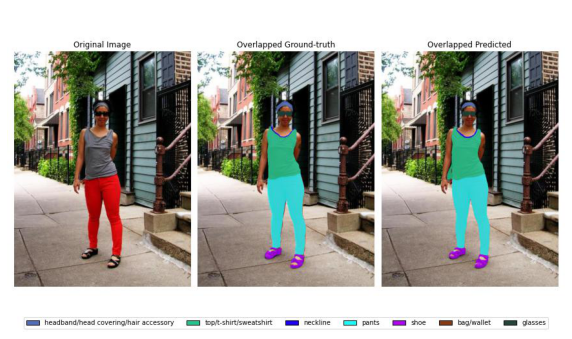

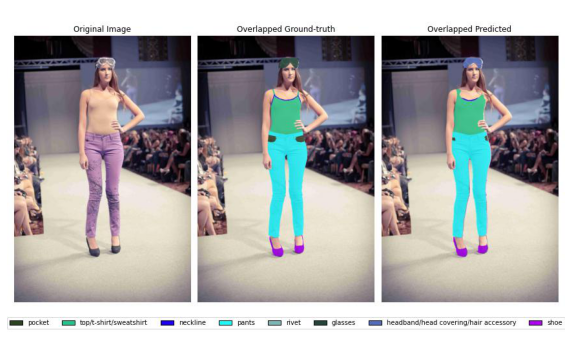

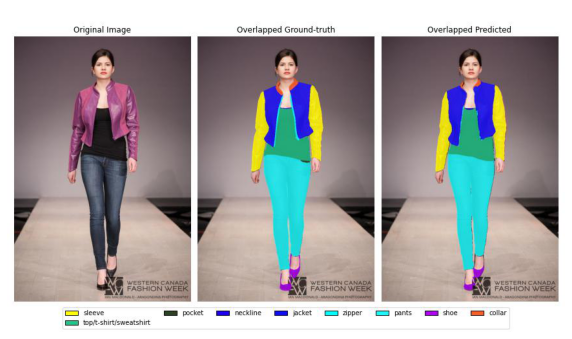

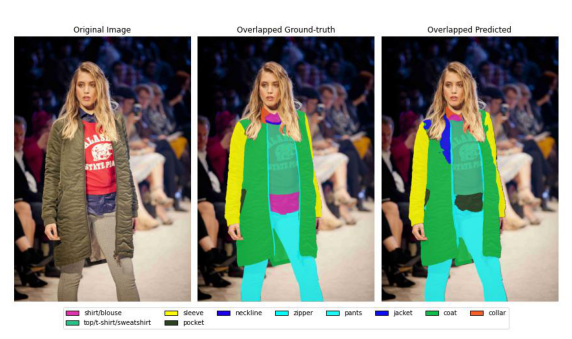

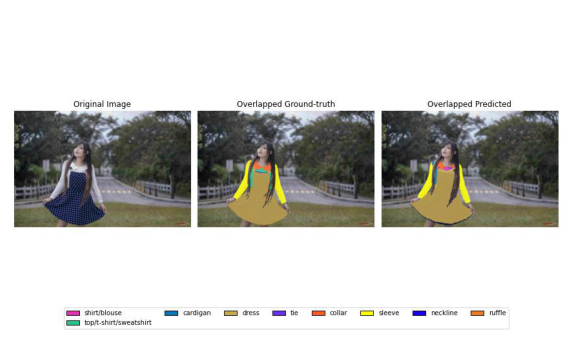

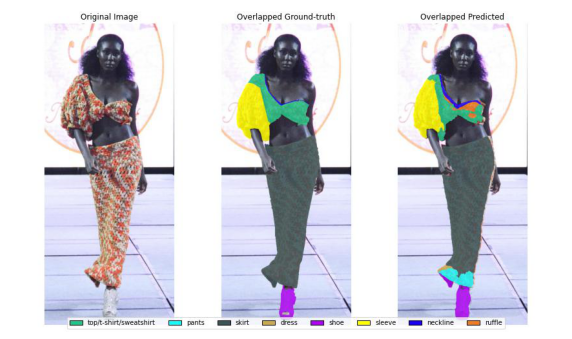

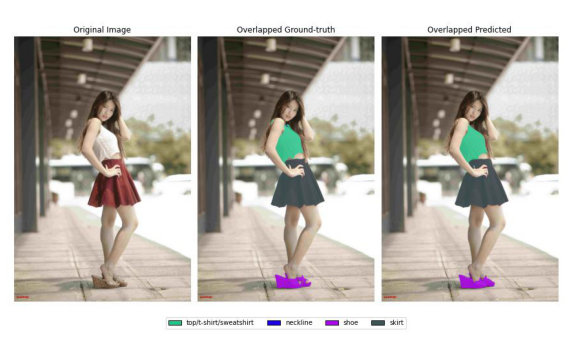

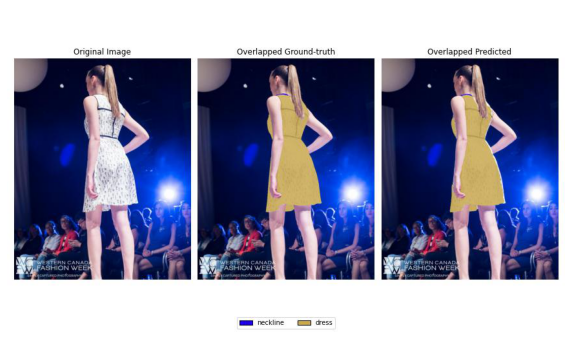

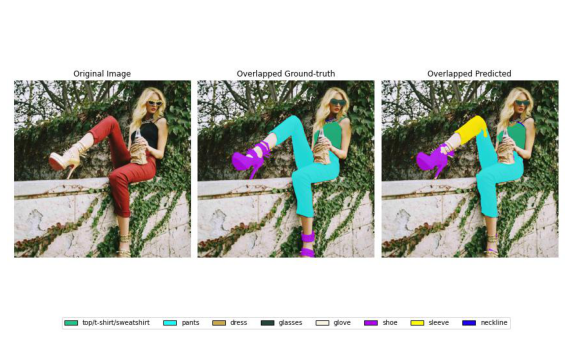

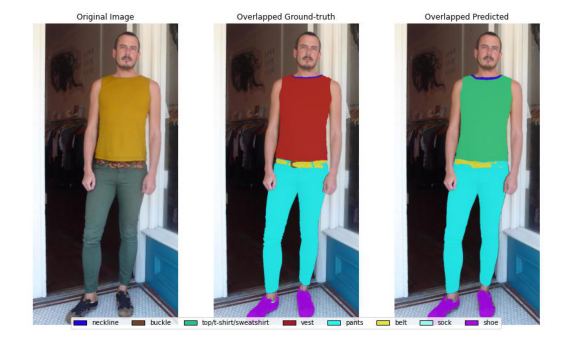

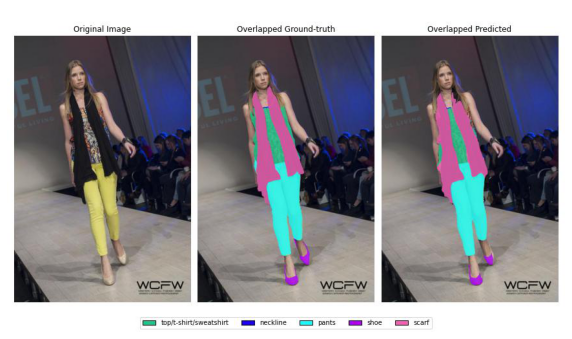

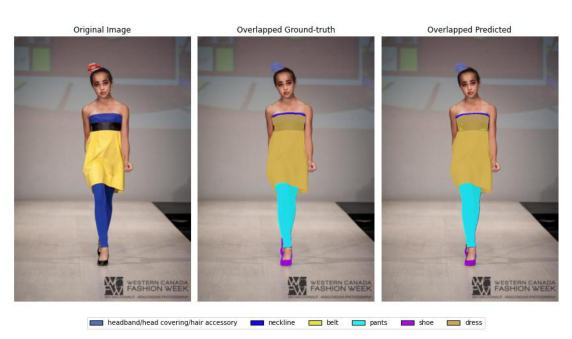

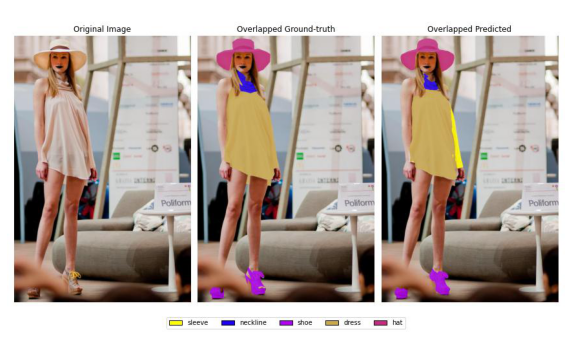

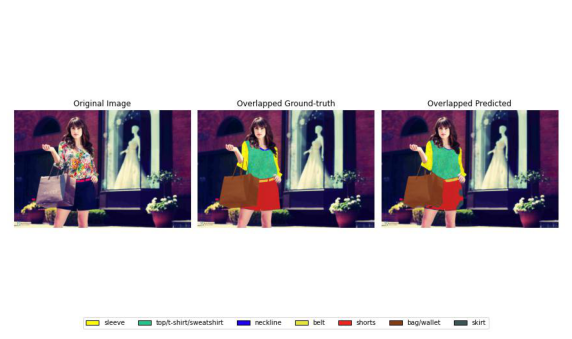

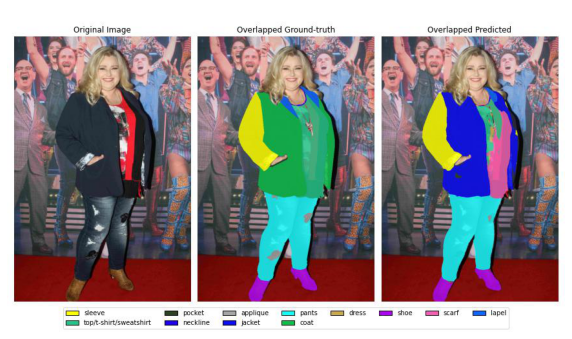

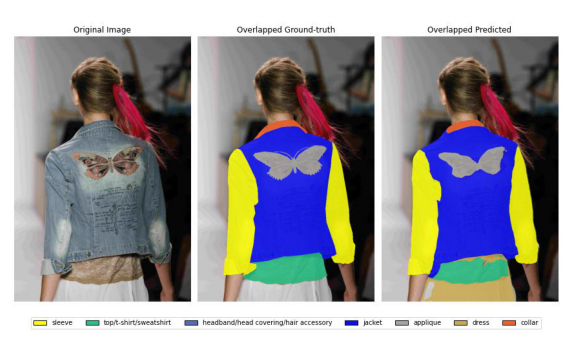

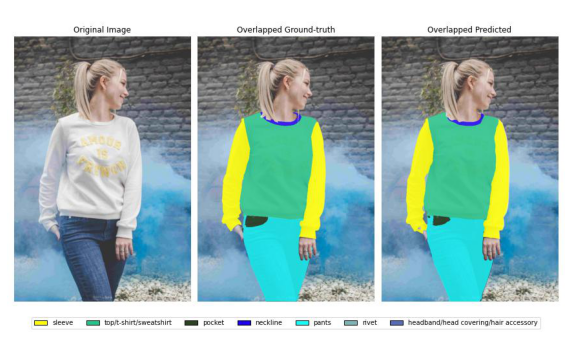

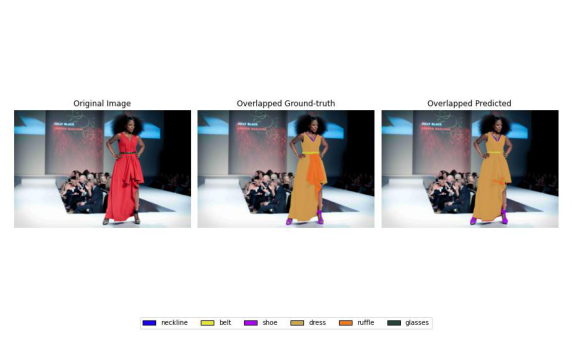

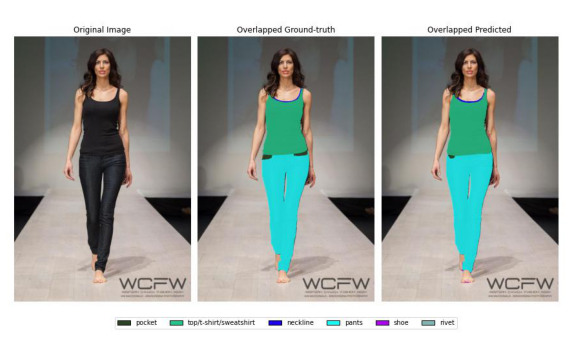

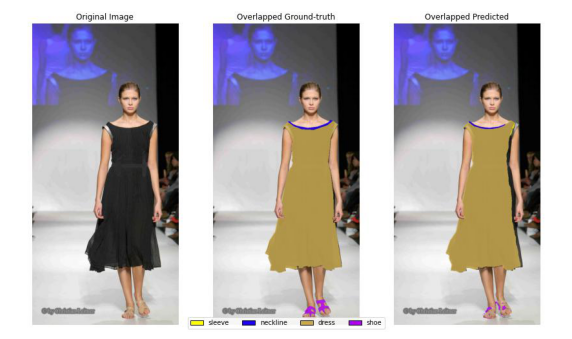

In [5]:
# Using the comparison images generated before

predictions = os.listdir(predictions_image_path)
num_test_images = len(predictions)
num_to_show = 20
indices = np.random.choice(num_test_images, num_to_show)

for index in indices:
    path = os.path.join(predictions_image_path, predictions[index])
    image = mpimg.imread(path)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)